# Ranking on directed graphs

Here we check the ranking for directed graphs, such as, . 

## Programs

These programs are collected from the file "Ranking on nodes directed graph with damping factor.ipynb". Check that file for detailed description.

In [1]:
import math as math
import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as lin
import numpy as np
import sympy as sym
from networkx.drawing.nx_pydot import graphviz_layout
import pandas as pd

In [2]:
pi = np.pi

In [3]:
def ket_vector(n, v):
    ket = [0] * n
    ket[v] = 1
    return np.matrix(ket).transpose()

In [4]:
def w_coeff(n, u_0, k):
    return(np.exp(2J*pi * u_0 * k / n))

In [5]:
def Weyl(n, u_0, u_l):
    z = np.matrix(np.zeros((n ,n)))
    for k in range(n):
        w = w_coeff(n, u_0, k)
        z = z + w * ket_vector(n, k) * ket_vector(n, (k + u_l) % n).transpose()
    return(z)

In [6]:
def make_directed(G):
    V = list(G.nodes())
    Vdict = {}
    for v in V:
        E = [(v, v)]
        for u in G.neighbors(v):
            E.append((v,u))
        Vdict[v] = E
    return(Vdict)

In [7]:
def Kraus_dictionary(G):
    n = G.order()
    Kdict = {}
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    for u_0 in list(G.nodes()):
        d = G.out_degree(u_0) + 1
        Kdict[(u_0, u_0)] = np.matrix(np.eye(n))/math.sqrt(d)
        for u_l in G.neighbors(u_0):
            Kdict[(u_0, u_l)] = Weyl(n, u_0, u_l)/math.sqrt(d)
    return(Kdict)

In [8]:
def initial_state(G):
    n = G.order()
    I = np.matrix(np.eye(n))
    list_of_density_matrices = [I/n**2]*n
    return(list_of_density_matrices)

In [9]:
def evolve(G, IS, T):
    n = G.order()
    V = list(G.nodes())
    M = IS.copy()
    Kdict = Kraus_dictionary(G)
    for t in range(0, T):
#         print("t = ", t)
        L = [np.matrix(np.zeros((n , n)))]*n
        for i in range(n):
            u_0 = V[i]
            E = []
            E = list(G.in_edges(u_0)) + [(u_0, u_0)]
            for e in E:
                L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
        P = []
        for i in range(n):
            M[i] = L[i]
            P.append(np.around(np.trace(M[i]), 4))
#         print(P)
    dic = {}
    for i in range(n):
        dic[i] = P[i]
    return(dic)

In [10]:
def evolve_with_damping(G, IS, T, alpha):
    n = G.order()
    V = list(G.nodes())
    M = IS.copy()
    Kdict = Kraus_dictionary(G)
    for t in range(0, T):
#         print("t = ", t)
        L = [np.matrix(np.zeros((n , n)))]*n
        for i in range(n):
            u_0 = V[i]
            E = []
            E = list(G.in_edges(u_0)) + [(u_0, u_0)]
            for e in E:
                L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
        P = []
        Dump = sum(M)
        for i in range(n):
#             M[i] = L[i]
            M[i] = alpha * L[i] + (1 - alpha) * Dump / n
            P.append(np.around(np.trace(M[i]), 4))
#         print(P)
#     dic = {}
#     for i in range(n):
#         dic[i] = P[i]
    return(P)

In [11]:
def one_step_evolution(G, alpha, M):
    n = G.order()
    V = list(G.nodes())
    Kdict = Kraus_dictionary(G)
    L = [np.matrix(np.zeros((n , n)))]*n
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    for i in range(n):
        u_0 = V[i]
        E = []
        E = list(G.in_edges(u_0)) + [(u_0, u_0)]
        for e in E:
            L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
    Dump = sum(M)
    for i in range(n):
        L[i] = alpha * L[i] + (1 - alpha) * Dump / n
    return(L)

In [12]:
def find_probability(M):
    n = len(M)
    P = []
    for i in range(n):
        P.append(np.around(np.trace(M[i]), 4))
    return(P)

In [13]:
def q_rank(G, alpha):
    n = G.order()
    V = list(G.nodes())
    Kdict = Kraus_dictionary(G)
    IS = initial_state(G)
    M = IS.copy()
    P = []
    P = find_probability(M)
    Q = [1]*n
    t = 1
    while lin.norm(np.array(P) - np.array(Q)) >= .0001:
        P = []
        P = Q
#         print(P)
        L = one_step_evolution(G, .85, M)
        Q = []
        Q = find_probability(L)
#         print(Q)
        M = []
        M = L.copy()
        t = t + 1
    dic = {}
    for i in range(n):
        dic[i] = np.real(np.around(Q[i], 4))
    return(dic, t)

In [14]:
def Google_matrix(G, alpha):
    n = G.order()
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    O = np.ones(n)
    A = nx.adjacency_matrix(G).A
    S = np.zeros((n, n))
    for i in range(n):
        if G.out_degree(i) != 0:
            d = G.out_degree(i)
            S[i] = A[i]/d
        else:
            S[i] = np.ones(n)/n
    Google = alpha * S + (1 - alpha)*O/n
    return(Google)

In [15]:
def page_rank(G, alpha):
    Google = np.matrix(Google_matrix(G, alpha))
    n = G.order()
    w = np.ones(n) / n
    v = w*Google
    t = 1
    while np.linalg.norm(w - v) >= .0001:
        w = v
        v = w*Google
        t = t + 1
    dic = {}
    v = np.array(v)[0]
    for i in range(n):
        dic[i] = v[i]
    return(dic, t)
#     return(v)

## Examples on undirected graphs

### Directed Trinary tree

In [16]:
r = 3
h = 2
H = nx.balanced_tree(r, h)

Here we take the edge orientations from the center to the outer layer. 

In [17]:
G = nx.DiGraph()
H.add_nodes_from(H.nodes())
E = list(H.edges())
G.add_edges_from(E)

Thanks to https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx

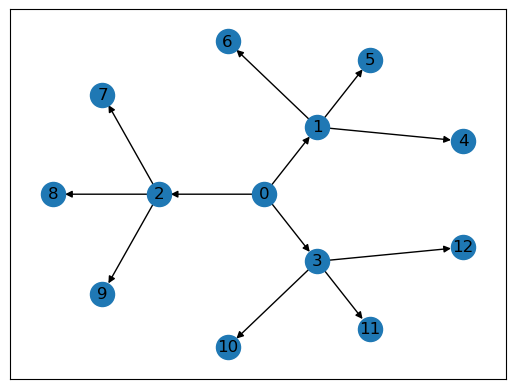

In [18]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

In [19]:
P = nx.pagerank(G)
for key in P.keys():
    P[key] = round(P[key], 4)
P

{0: 0.0584,
 1: 0.0749,
 2: 0.0749,
 3: 0.0749,
 4: 0.0796,
 5: 0.0796,
 6: 0.0796,
 7: 0.0796,
 8: 0.0796,
 9: 0.0796,
 10: 0.0796,
 11: 0.0796,
 12: 0.0796}

In [20]:
Q, t = q_rank(G, .85)
Q

{0: 0.0147,
 1: 0.0186,
 2: 0.0186,
 3: 0.0186,
 4: 0.1033,
 5: 0.1033,
 6: 0.1033,
 7: 0.1033,
 8: 0.1033,
 9: 0.1033,
 10: 0.1033,
 11: 0.1033,
 12: 0.1033}

In [21]:
P1 = np.real(list(P.values()))
P1

array([0.0584, 0.0749, 0.0749, 0.0749, 0.0796, 0.0796, 0.0796, 0.0796,
       0.0796, 0.0796, 0.0796, 0.0796, 0.0796])

In [22]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0147, 0.0186, 0.0186, 0.0186, 0.1033, 0.1033, 0.1033, 0.1033,
       0.1033, 0.1033, 0.1033, 0.1033, 0.1033])

In [23]:
new_dict = pd.DataFrame([P1,Q1]).to_dict('list')
new_dict

{0: [0.0584, 0.0147],
 1: [0.0749, 0.0186],
 2: [0.0749, 0.0186],
 3: [0.0749, 0.0186],
 4: [0.0796, 0.1033],
 5: [0.0796, 0.1033],
 6: [0.0796, 0.1033],
 7: [0.0796, 0.1033],
 8: [0.0796, 0.1033],
 9: [0.0796, 0.1033],
 10: [0.0796, 0.1033],
 11: [0.0796, 0.1033],
 12: [0.0796, 0.1033]}

In [24]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

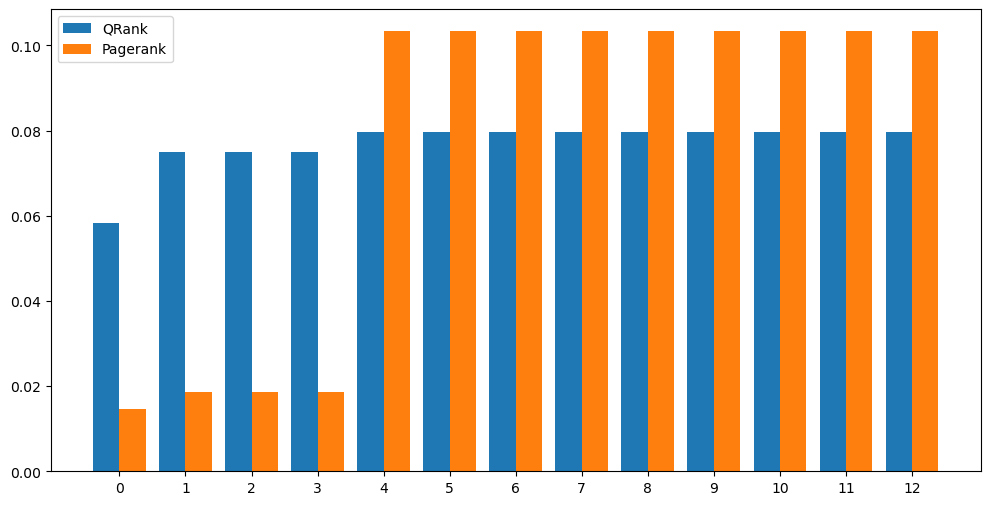

In [25]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [26]:
r = 3
h = 2
H = nx.balanced_tree(r, h)

Here we take the edge orientations from the outer layer to the center.

In [27]:
G = nx.DiGraph()
H.add_nodes_from(H.nodes())
E = list(H.edges())
F = []
for edge in E:
    F.append((edge[1], edge[0]))
G.add_edges_from(F)

Thanks to https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx

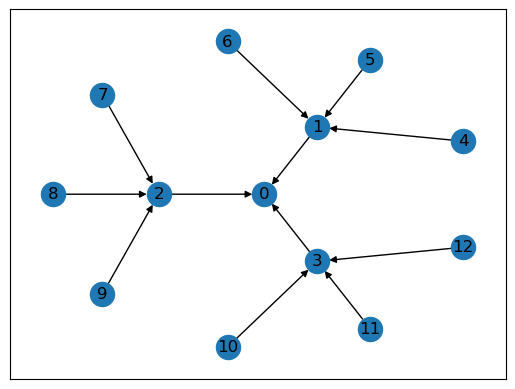

In [28]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

In [29]:
P = nx.pagerank(G)
for key in P.keys():
    P[key] = round(P[key], 4)
P

{1: 0.1195,
 0: 0.3384,
 2: 0.1195,
 3: 0.1195,
 4: 0.0337,
 5: 0.0337,
 6: 0.0337,
 7: 0.0337,
 8: 0.0337,
 9: 0.0337,
 10: 0.0337,
 11: 0.0337,
 12: 0.0337}

In [30]:
Q, t = q_rank(G, .85)
Q

{0: 0.2319,
 1: 0.4583,
 2: 0.0646,
 3: 0.0646,
 4: 0.0201,
 5: 0.0201,
 6: 0.0201,
 7: 0.0201,
 8: 0.0201,
 9: 0.0201,
 10: 0.0201,
 11: 0.0201,
 12: 0.0201}

In [31]:
t

14

In [32]:
P1 = np.real(list(P.values()))
P1

array([0.1195, 0.3384, 0.1195, 0.1195, 0.0337, 0.0337, 0.0337, 0.0337,
       0.0337, 0.0337, 0.0337, 0.0337, 0.0337])

In [33]:
Q1 = np.real(list(Q.values()))
Q1

array([0.2319, 0.4583, 0.0646, 0.0646, 0.0201, 0.0201, 0.0201, 0.0201,
       0.0201, 0.0201, 0.0201, 0.0201, 0.0201])

In [34]:
X = list(G.nodes())
X

[1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [35]:
new_dict = pd.DataFrame([P1,Q1]).to_dict('list')
new_dict

{0: [0.1195, 0.2319],
 1: [0.3384, 0.4583],
 2: [0.1195, 0.0646],
 3: [0.1195, 0.0646],
 4: [0.0337, 0.0201],
 5: [0.0337, 0.0201],
 6: [0.0337, 0.0201],
 7: [0.0337, 0.0201],
 8: [0.0337, 0.0201],
 9: [0.0337, 0.0201],
 10: [0.0337, 0.0201],
 11: [0.0337, 0.0201],
 12: [0.0337, 0.0201]}

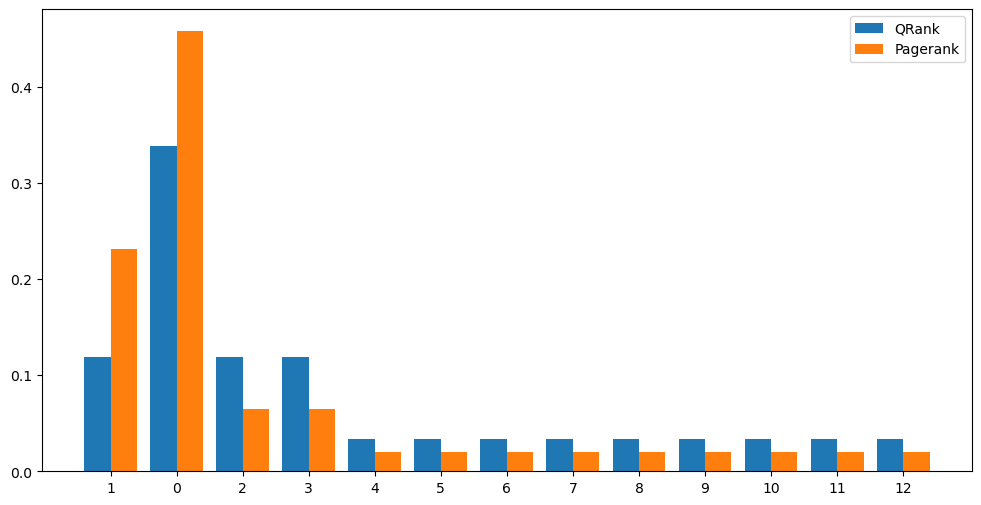

In [36]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Scale free graph

B. Bollobás, C. Borgs, J. Chayes, and O. Riordan, Directed scale-free graphs, Proceedings of the fourteenth annual ACM-SIAM Symposium on Discrete Algorithms, 132–139, 2003.

Here the graph may have loops in the vertices. We remove the loops after generating the graph. Also, we calculate the ranks for connected graphs only.

In [37]:
G = nx.scale_free_graph(20)
G.remove_edges_from(nx.selfloop_edges(G))
nx.is_weakly_connected(G)

True

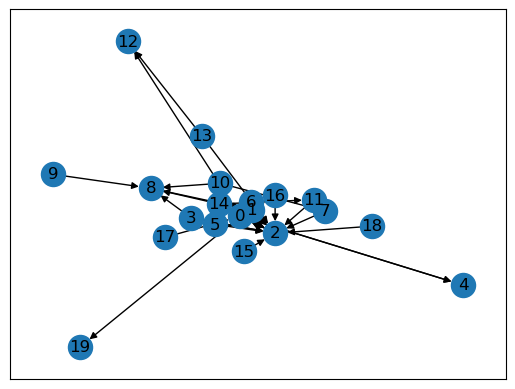

In [38]:
nx.draw_networkx(G)

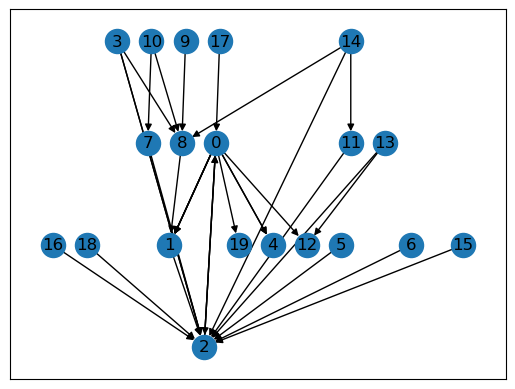

In [39]:
pos = graphviz_layout(G, prog="dot")
nx.draw_networkx(G, pos)
plt.show()

In [40]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_20049/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.24433939540508628,
 1: 0.13798738094401933,
 2: 0.25832806424315535,
 3: 0.0133675798305713,
 4: 0.05952910743713067,
 5: 0.0133675798305713,
 6: 0.0133675798305713,
 7: 0.01904947226984387,
 8: 0.037989113734085776,
 9: 0.0133675798305713,
 10: 0.0133675798305713,
 11: 0.01715550812341968,
 12: 0.04213023607312356,
 13: 0.0133675798305713,
 14: 0.0133675798305713,
 15: 0.0133675798305713,
 16: 0.0133675798305713,
 17: 0.0133675798305713,
 18: 0.0133675798305713,
 19: 0.03644834363385098}

In [41]:
t

18

In [42]:
Q, t = q_rank(G, .85)
Q

{0: 0.1122,
 1: 0.1052,
 2: 0.1581,
 3: 0.0095,
 4: 0.1769,
 5: 0.013,
 6: 0.013,
 7: 0.0182,
 8: 0.0349,
 9: 0.013,
 10: 0.0105,
 11: 0.0166,
 12: 0.1332,
 13: 0.0105,
 14: 0.0095,
 15: 0.013,
 16: 0.013,
 17: 0.013,
 18: 0.013,
 19: 0.1135}

In [43]:
t

27

In [44]:
P1 = np.real(list(P.values()))
P1

array([0.2443394 , 0.13798738, 0.25832806, 0.01336758, 0.05952911,
       0.01336758, 0.01336758, 0.01904947, 0.03798911, 0.01336758,
       0.01336758, 0.01715551, 0.04213024, 0.01336758, 0.01336758,
       0.01336758, 0.01336758, 0.01336758, 0.01336758, 0.03644834])

In [45]:
Q1 = np.real(list(Q.values()))
Q1

array([0.1122, 0.1052, 0.1581, 0.0095, 0.1769, 0.013 , 0.013 , 0.0182,
       0.0349, 0.013 , 0.0105, 0.0166, 0.1332, 0.0105, 0.0095, 0.013 ,
       0.013 , 0.013 , 0.013 , 0.1135])

In [46]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

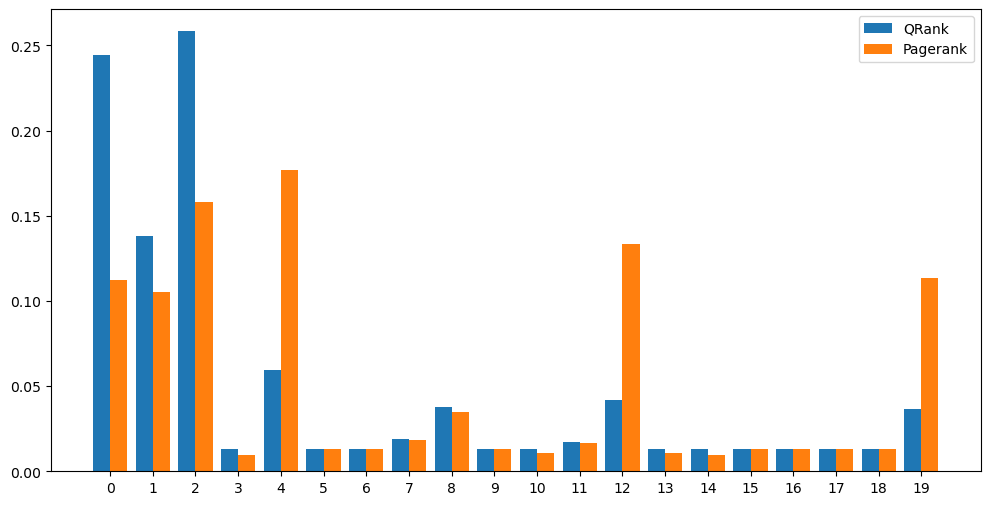

In [47]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### erdos_renyi_graph

[1] Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).
[2] Gilbert, Random Graphs, Ann. Math. Stat., 30, 1141 (1959).

https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html

Here the graph may have loops in the vertices. We remove the loops after generating the graph. Also, we calculate the ranks for connected graphs only.

In [48]:
G = nx.erdos_renyi_graph(20, .1, seed = None, directed = True)
G.remove_edges_from(nx.selfloop_edges(G))
nx.is_weakly_connected(G)

True

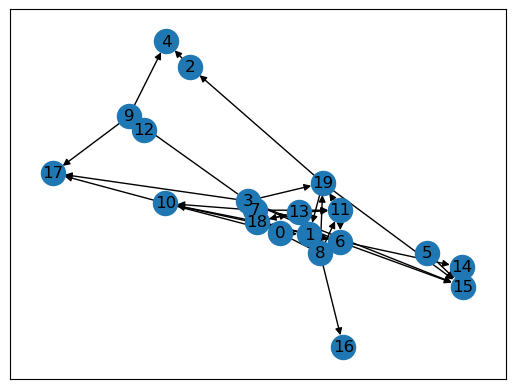

In [49]:
nx.draw_networkx(G)

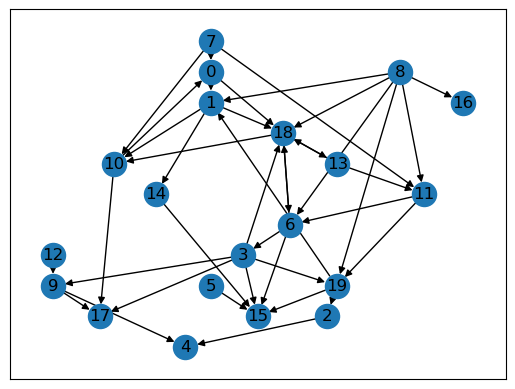

In [50]:
pos = graphviz_layout(G, prog="dot")
nx.draw_networkx(G, pos)
plt.show()

In [51]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_20049/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.054448939886616046,
 1: 0.05823988357774497,
 2: 0.03244372210464907,
 3: 0.039334973658147455,
 4: 0.0638925497117781,
 5: 0.018732708142657234,
 6: 0.07273070570004664,
 7: 0.018732708142657234,
 8: 0.018732708142657234,
 9: 0.04134433173277121,
 10: 0.07155674888702973,
 11: 0.047833050029781915,
 12: 0.018732708142657234,
 13: 0.04974540462563001,
 14: 0.03523621817007443,
 15: 0.10560700827849079,
 16: 0.021386625259648497,
 17: 0.07340151911874447,
 18: 0.10946135658297786,
 19: 0.04840613010524027}

In [52]:
t

10

In [53]:
Q, t = q_rank(G, .85)
Q

{0: 0.0274,
 1: 0.0268,
 2: 0.0214,
 3: 0.0169,
 4: 0.1514,
 5: 0.013,
 6: 0.0329,
 7: 0.0095,
 8: 0.0085,
 9: 0.0215,
 10: 0.0357,
 11: 0.0246,
 12: 0.013,
 13: 0.025,
 14: 0.023,
 15: 0.2466,
 16: 0.0569,
 17: 0.174,
 18: 0.0488,
 19: 0.0227}

In [54]:
t

24

In [55]:
P1 = np.real(list(P.values()))
P1

array([0.05444894, 0.05823988, 0.03244372, 0.03933497, 0.06389255,
       0.01873271, 0.07273071, 0.01873271, 0.01873271, 0.04134433,
       0.07155675, 0.04783305, 0.01873271, 0.0497454 , 0.03523622,
       0.10560701, 0.02138663, 0.07340152, 0.10946136, 0.04840613])

In [56]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0274, 0.0268, 0.0214, 0.0169, 0.1514, 0.013 , 0.0329, 0.0095,
       0.0085, 0.0215, 0.0357, 0.0246, 0.013 , 0.025 , 0.023 , 0.2466,
       0.0569, 0.174 , 0.0488, 0.0227])

In [57]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

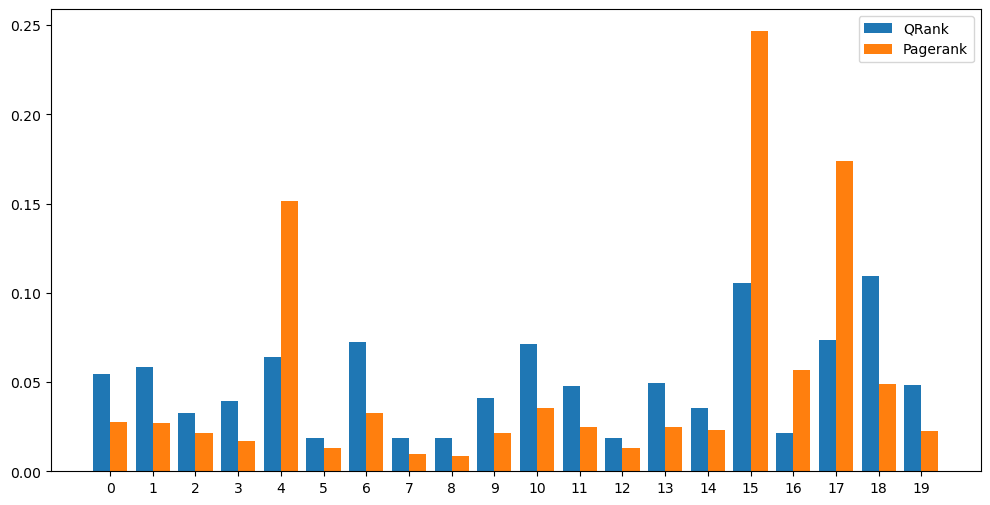

In [58]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### random k out graph

Peterson, Nicholas R., and Boris Pittel. “Distance between two random k-out digraphs, with and without preferential attachment.” arXiv preprint arXiv:1311.5961 (2013). <https://arxiv.org/abs/1311.5961>

https://networkx.org/documentation/stable/reference/generated/networkx.generators.directed.random_k_out_graph.html

Here the graph may have loops in the vertices. We remove the loops after generating the graph. Also, we calculate the ranks for connected graphs only.

In [59]:
G = nx.random_k_out_graph(20, 3, 1, self_loops = False, seed=None)
# G.remove_edges_from(nx.selfloop_edges(G))
nx.is_weakly_connected(G)

True

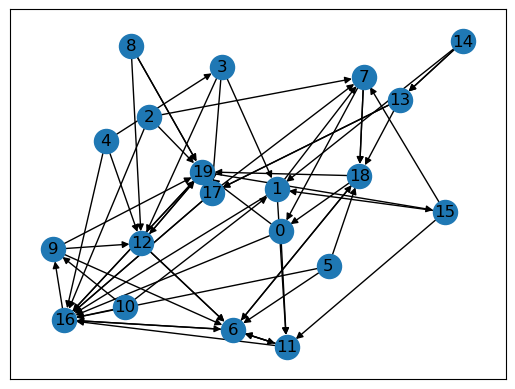

In [60]:
nx.draw_networkx(G)

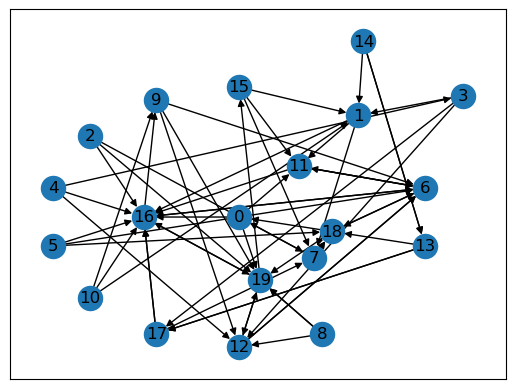

In [61]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

In [62]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_20049/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.04126670860841464,
 1: 0.02696976712478049,
 2: 0.007500000000000003,
 3: 0.009625000000000003,
 4: 0.007500000000000003,
 5: 0.007500000000000003,
 6: 0.18387577253092724,
 7: 0.03454235230270298,
 8: 0.007500000000000003,
 9: 0.054815161964732316,
 10: 0.007500000000000003,
 11: 0.09140159666985423,
 12: 0.06658493020193187,
 13: 0.011750000000000003,
 14: 0.007500000000000003,
 15: 0.04408051680869059,
 16: 0.15946349433471022,
 17: 0.01688541666666667,
 18: 0.084607889115945,
 19: 0.12913139367064394}

In [63]:
t

12

In [64]:
Q, t = q_rank(G, .85)
Q

{0: 0.042,
 1: 0.0296,
 2: 0.0095,
 3: 0.0121,
 4: 0.0095,
 5: 0.0095,
 6: 0.1735,
 7: 0.0374,
 8: 0.0095,
 9: 0.0537,
 10: 0.0095,
 11: 0.0873,
 12: 0.0662,
 13: 0.0147,
 14: 0.0095,
 15: 0.0433,
 16: 0.1544,
 17: 0.0207,
 18: 0.083,
 19: 0.125}

In [65]:
t

11

In [66]:
P1 = np.real(list(P.values()))
P1

array([0.04126671, 0.02696977, 0.0075    , 0.009625  , 0.0075    ,
       0.0075    , 0.18387577, 0.03454235, 0.0075    , 0.05481516,
       0.0075    , 0.0914016 , 0.06658493, 0.01175   , 0.0075    ,
       0.04408052, 0.15946349, 0.01688542, 0.08460789, 0.12913139])

In [67]:
Q1 = np.real(list(Q.values()))
Q1

array([0.042 , 0.0296, 0.0095, 0.0121, 0.0095, 0.0095, 0.1735, 0.0374,
       0.0095, 0.0537, 0.0095, 0.0873, 0.0662, 0.0147, 0.0095, 0.0433,
       0.1544, 0.0207, 0.083 , 0.125 ])

In [68]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

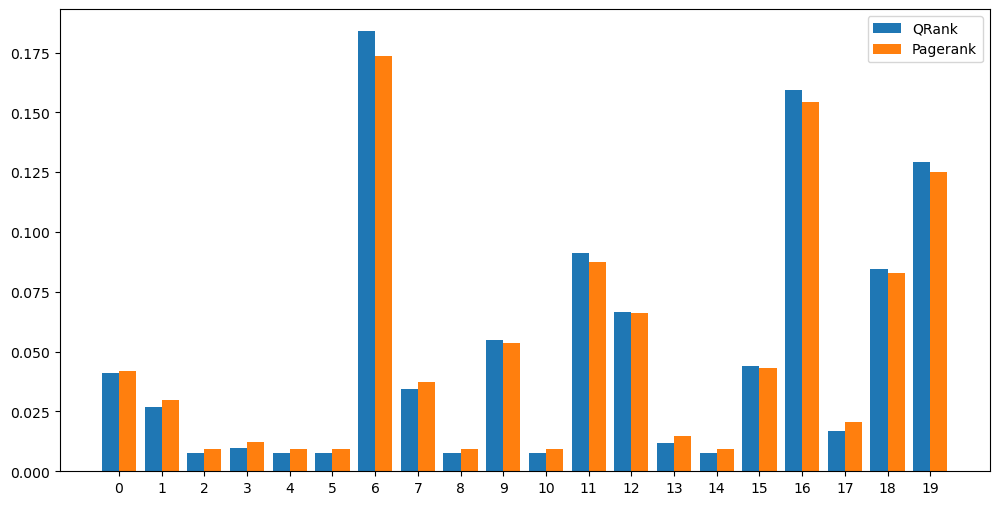

In [69]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### GNC network

P. L. Krapivsky and S. Redner, Network Growth by Copying, Phys. Rev. E, 71, 036118, 2005k.}

https://networkx.org/documentation/stable/reference/generated/networkx.generators.directed.gnc_graph.html

Here the graph may have loops in the vertices. We remove the loops after generating the graph. Also, we calculate the ranks for connected graphs only.

In [70]:
G = nx.gnc_graph(20, create_using=None, seed=None)
G.remove_edges_from(nx.selfloop_edges(G))
nx.is_weakly_connected(G)

True

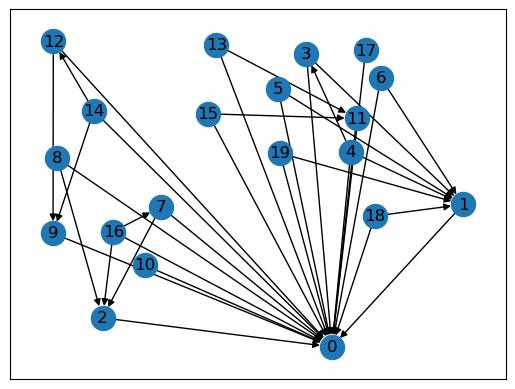

In [71]:
nx.draw_networkx(G)

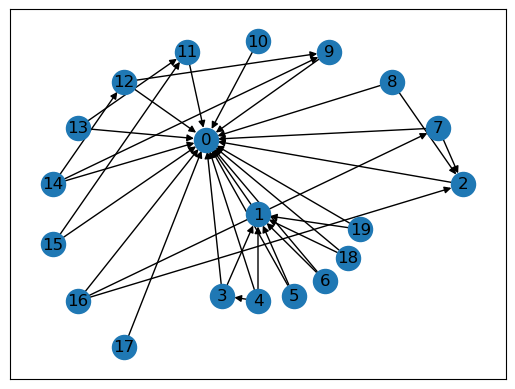

In [72]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

In [73]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_20049/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.3902921411121526,
 1: 0.0849932552377056,
 2: 0.05428616184934815,
 3: 0.030913497690939137,
 4: 0.02408969916019304,
 5: 0.02408969916019304,
 6: 0.02408969916019304,
 7: 0.030913497690939137,
 8: 0.02408969916019304,
 9: 0.044050464053228995,
 10: 0.02408969916019304,
 11: 0.04456109475243133,
 12: 0.030913497690939137,
 13: 0.02408969916019304,
 14: 0.02408969916019304,
 15: 0.02408969916019304,
 16: 0.02408969916019304,
 17: 0.02408969916019304,
 18: 0.02408969916019304,
 19: 0.02408969916019304}

In [74]:
t

12

In [75]:
Q, t = q_rank(G, .85)
Q

{0: 0.7137,
 1: 0.0438,
 2: 0.0283,
 3: 0.0133,
 4: 0.0095,
 5: 0.0105,
 6: 0.0105,
 7: 0.0133,
 8: 0.0105,
 9: 0.0231,
 10: 0.013,
 11: 0.0234,
 12: 0.0133,
 13: 0.0105,
 14: 0.0095,
 15: 0.0105,
 16: 0.0095,
 17: 0.013,
 18: 0.0105,
 19: 0.0105}

In [76]:
t

13

In [77]:
P1 = np.real(list(P.values()))
P1

array([0.39029214, 0.08499326, 0.05428616, 0.0309135 , 0.0240897 ,
       0.0240897 , 0.0240897 , 0.0309135 , 0.0240897 , 0.04405046,
       0.0240897 , 0.04456109, 0.0309135 , 0.0240897 , 0.0240897 ,
       0.0240897 , 0.0240897 , 0.0240897 , 0.0240897 , 0.0240897 ])

In [78]:
Q1 = np.real(list(Q.values()))
Q1

array([0.7137, 0.0438, 0.0283, 0.0133, 0.0095, 0.0105, 0.0105, 0.0133,
       0.0105, 0.0231, 0.013 , 0.0234, 0.0133, 0.0105, 0.0095, 0.0105,
       0.0095, 0.013 , 0.0105, 0.0105])

In [79]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

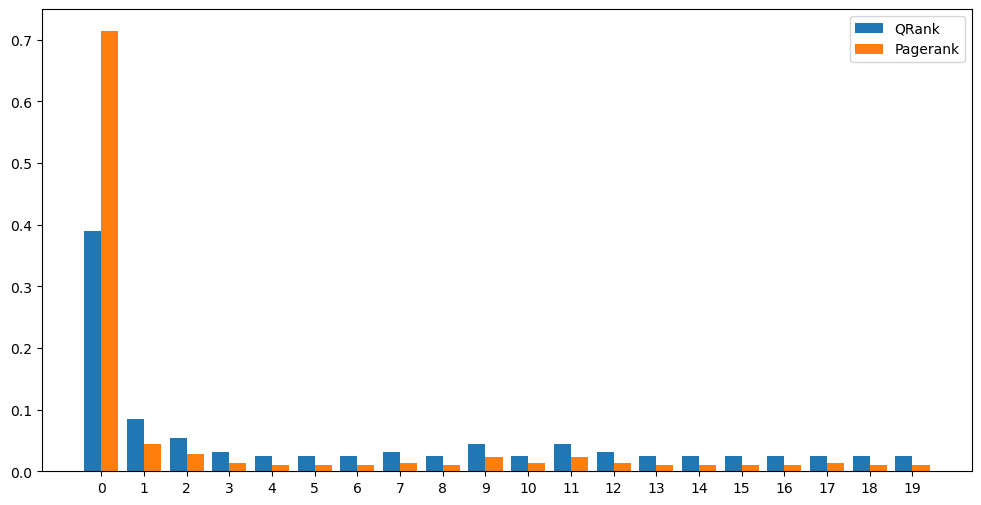

In [80]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 